In [1]:
import snowflake.connector
from datetime import datetime, date
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np                  
import matplotlib.pyplot as plt     
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
import seaborn as sns
from math import floor 
from scipy.optimize import curve_fit

/Users/nfiguera/.local/share/virtualenvs/data-science-mn1T8veA/lib/python3.8/site-packages/snowflake/connector/options.py:94: UserWarning: You have an incompatible version of 'pyarrow' installed (6.0.1), please install a version that adheres to: 'pyarrow<5.1.0,>=5.0.0; extra == "pandas"'
  warn_incompatible_dep(


In [7]:
from gitlabdata.orchestration_utils import (
    query_dataframe,
    query_executor,
    snowflake_engine_factory,
    snowflake_stage_load_copy_remove,
)
from os import environ as env


snowflake_engine = snowflake_engine_factory(env, "SALES_ANALYTICS")

raw_db_name = env["SNOWFLAKE_LOAD_DATABASE"]

snowflake_engine

KeyError: 'SALES_ANALYTICS_LOADER'

# Model Description:

## Goal

Retrieve the quarterly coverage raw data & calculate fitted coverage curves for each level of aggregation
 
## Steps

- Retrieve data metrics per day models
- Calculate the quarters needed for each metric
- Integrate the different cuts into a single tall table
- Pre-aggregate the data by business cut & calculate coverage
- Using pre-aggregated data, fit a curve for each pre-aggregated model
- Push changes to gSheet

## Challenges with automation

- How can we authenticate on gSheets without using my own auth json. (Maybe a service account within the library)?
- How can we push data into Snowflake, ideally the workspace_sales directly from the jupyter workbook?


## Update to FY / 4Q historical curves

List of steps:
- Create metric per day for FY
- How to create a metric day perspective for 4Q cuts?
  - Starting quarter and end quarter
  - Total booked on that time period
  - Day 365 is the last day of end quarter
 

# Helper Functions

In [4]:
#######
## Create a fitter curve of the last 4 quarters for comparison
#######
def objective(x, a, b, c, d, e):
    return a * x + b * x**2 + c * x**3 + d * x**4 + e

def run_query_in_snowflake(conn, sql):
    cur = conn.cursor()
    cur.execute(sql)
    df = cur.fetch_pandas_all()
    return df

def executeScriptFromFile(filename, engine):
    # Open and read the file as a single buffer
    fd = open(filename, 'r')
    sqlFile = fd.read()
    fd.close()
    
    print(filename)
    print(len(sqlFile))
    
    results = -1
    
    try:
        results = query_dataframe(engine,sqlFile)
    except:
        print("Command did not run")
    
    return results

###########################################################

def days_between(d1, d2):
    #d1 = datetime.strptime(d1, "%Y-%m-%d")
    #d2 = datetime.strptime(d2, "%Y-%m-%d")
    return (d2 - d1).days


def calculate_quarters_after_creation(x):
        
    age = 0
    
    if (x['IS_OPEN'] == 1):
        age = days_between(x['CREATED_FISCAL_QUARTER_DATE'], x['SNAPSHOT_FISCAL_QUARTER_DATE'])
    elif (x['IS_OPEN']== 0 and x['SNAPSHOT_DATE'] <= x['CLOSE_DATE']):
        age = days_between(x['CREATED_FISCAL_QUARTER_DATE'], x['SNAPSHOT_FISCAL_QUARTER_DATE'])
    else:
        age = days_between(x['CREATED_FISCAL_QUARTER_DATE'], x['CLOSE_FISCAL_QUARTER_DATE'])
    
    quarter_delta = floor(age/90)
    
    return quarter_delta

def calculate_channel_track (x):
    
    channel_track = 'Direct'
    
    if (x['deal_path'] == 'Direct'):
        channel_track = 'Direct'
    elif (x['deal_path'] == 'Web Direct'):
        channel_track = 'Web Direct'
    elif (x['deal_path'] == 'Channel'
        and x['sales_qualified_source'] != 'Channel Generated'): 
        channel_track = 'Partner Co-Sell'
    elif (x['deal_path'] == 'Channel'):
        channel_track = 'Partner Sourced'
    
    return channel_track

In [5]:
# calculates pending coverage using a minimum of 50k pending
def calculate_to_pending_coverage (x, metric, qtd, actual, minimum_delta=5000):
    
    result = None
    
    actual = float(x[actual])
    qtd = float(x[qtd])
    metric = float(x[metric])
    
    if (actual - qtd) > minimum_delta:
        result = metric / (actual - qtd)
        result = min(result,6) # limiting the maximum amount of coverage to account for noise in the models
    
    return result

# calculates pending coverage using a minimum of 50k pending
def calculate_bookings_linearity (x, qtd_bookings, actual_booked):
    
    result = None
    
    actual = float(x[actual_booked])
    qtd = float(x[qtd_bookings])
       
    if actual > 0:
        result = qtd / actual 
        
    return result 


# fits a curve to the subset data using the defined objective function
def fit_curve_to_agg (data_agg, x_label, y_label):
    
    # fit a curve
    x, y = data_agg[x_label], data_agg[y_label]
    # curve fit
    popt, _ = curve_fit(objective, x, y, method='dogbox')

    x_line = np.arange(min(x), max(x), 1)
    # calculate the output for the range
    # summarize the parameter values
    a, b, c , d, e = popt
    y_line = objective(x_line, a, b, c, d, e)
  
    curve_result = pd.DataFrame({x_label:x_line,y_label:y_line})
    return curve_result

## Data Collection

In [6]:

### considered keys
agg_key_list = ['key_segment','key_overall','sales_team_rd_asm_level',
        'key_sqs', 'key_ot','key_segment_sqs', 'key_segment_ot', 'key_segment_geo', 'key_segment_geo_sqs',
        'key_segment_geo_ot', 'key_segment_geo_region',
        'key_segment_geo_region_sqs', 'key_segment_geo_region_ot',
        'key_segment_geo_region_area', 'key_segment_geo_region_area_sqs','key_ent_comm',
        'key_segment_geo_region_area_ot','report_user_segment_geo_region_area','key_alliance_partner',
        'key_alliance_partner_ot',
        'key_channel_category',
        'key_channel_category_segment',
        'key_channel_category_segment_geo',
        'key_channel_category_ot',
        'key_channel_category_segment_ot',
        'key_channel_category_segment_geo_ot',
        'key_segment_comcat',
        'key_segment_geo_comcat'] #

In [7]:
# Collect quarterly data
sql_file = 'qtr_metrics_by_day_channel'

print ("Executing {} Snowflake SQL".format(sql_file))
qtr_metrics_by_day = executeScriptFromFile(sql_file+'.sql', engine)

Executing qtr_metrics_by_day_channel Snowflake SQL
qtr_metrics_by_day_channel.sql
38540


In [8]:
# extracted quarters
qtr_metrics_by_day.close_fiscal_quarter_name.sort_values().unique()

array(['FY20-Q3', 'FY20-Q4', 'FY21-Q1', 'FY21-Q2', 'FY21-Q3', 'FY21-Q4',
       'FY22-Q1', 'FY22-Q2', 'FY22-Q3', 'FY22-Q4', 'FY23-Q1', 'FY23-Q2',
       'FY23-Q3'], dtype=object)

In [9]:
index = (qtr_metrics_by_day['close_fiscal_quarter_name'] == 'FY22-Q3') & (qtr_metrics_by_day['close_day_of_fiscal_quarter_normalised'
]==90) & (qtr_metrics_by_day['key_segment_geo']=='large_emea')
qtr_metrics_by_day[index].groupby(['key_segment_geo'])['rq_plus_1_open_1plus_net_arr'].sum()

key_segment_geo
large_emea    33423108.8
Name: rq_plus_1_open_1plus_net_arr, dtype: float64

# Data Transformation

We collect the data and identify the quarters that we need for each metric.

The way the model is construct, it will have for any given quarter values for open pipeline closing in the same quarter and in future quarters.

To calculate the Current Quarter + 1 & + 2 metrics, we use the specific future field and filter the close quarter to the right point in time


In [10]:
# transform potential strings to date (in case of data read from CSV)
qtr_metrics_by_day['close_fiscal_quarter_date'] = pd.to_datetime(qtr_metrics_by_day['close_fiscal_quarter_date']).dt.date
qtr_metrics_by_day['rq_plus_1_close_fiscal_quarter_date'] = pd.to_datetime(qtr_metrics_by_day['rq_plus_1_close_fiscal_quarter_date']).dt.date
qtr_metrics_by_day['rq_plus_2_close_fiscal_quarter_date'] = pd.to_datetime(qtr_metrics_by_day['rq_plus_2_close_fiscal_quarter_date']).dt.date

#################
##### Data Injections

# create an artificial global key to calculate a global curve for the whole company
qtr_metrics_by_day['key_overall'] = 'global'

# adjust the sales_team legacy key to be sure that it won't generate duplicate with the FY23 key logic
qtr_metrics_by_day['sales_team_rd_asm_level'] = 'st_rd_' + qtr_metrics_by_day['sales_team_rd_asm_level']

# add a commercial and enterprise consolidated key
#add key enterprise commercial for x-ray reporting
qtr_metrics_by_day['key_ent_comm'] = 'other'
qtr_metrics_by_day.loc[qtr_metrics_by_day['key_segment']=='large','key_ent_comm'] = 'enterprise'
qtr_metrics_by_day.loc[qtr_metrics_by_day['key_segment']=='pubsec','key_ent_comm'] = 'enterprise'
qtr_metrics_by_day.loc[qtr_metrics_by_day['key_segment']=='mid-market','key_ent_comm'] = 'commercial'
qtr_metrics_by_day.loc[qtr_metrics_by_day['key_segment']=='smb','key_ent_comm'] = 'commercial'

#################

# identify the quarters that will be considered when creating the curves
# for current quarter last 4 quarters
index_cond = (qtr_metrics_by_day['close_fiscal_quarter_date'] <= date.today() + relativedelta(months=-3)) & (qtr_metrics_by_day['close_fiscal_quarter_date'] >= date.today() + relativedelta(months=-15))
cq_considered_quarters = qtr_metrics_by_day[index_cond].close_fiscal_quarter_name.sort_values().unique()

# for current quarter + 1, between 5 and 1 quarter ago (as we need the total won amount of the quarter to calculate coverage)
index_cond = (qtr_metrics_by_day['close_fiscal_quarter_date'] <= date.today() + relativedelta(months=-6)) & (qtr_metrics_by_day['close_fiscal_quarter_date'] >= date.today() + relativedelta(months=-18))
cq_1plus_considered_quarters = qtr_metrics_by_day[index_cond].close_fiscal_quarter_name.sort_values().unique()

# for current quarter + 2, between 6 and 2 quarter ago (as we need the total won amount of the quarter to calculate coverage)
index_cond = (qtr_metrics_by_day['close_fiscal_quarter_date'] <= date.today() + relativedelta(months=-9)) & (qtr_metrics_by_day['close_fiscal_quarter_date'] >= date.today() + relativedelta(months=-21))
cq_2plus_considered_quarters = qtr_metrics_by_day[index_cond].close_fiscal_quarter_name.sort_values().unique()

print(cq_considered_quarters)
print(cq_1plus_considered_quarters)
print(cq_2plus_considered_quarters)

['FY22-Q3' 'FY22-Q4' 'FY23-Q1' 'FY23-Q2']
['FY22-Q2' 'FY22-Q3' 'FY22-Q4' 'FY23-Q1']
['FY22-Q1' 'FY22-Q2' 'FY22-Q3' 'FY22-Q4']


In [11]:
# separate considered data points per metric type
cq_metrics_data = qtr_metrics_by_day[qtr_metrics_by_day['close_fiscal_quarter_name'].isin(cq_considered_quarters)].copy()
cq_plus1_metrics_data = qtr_metrics_by_day[qtr_metrics_by_day['close_fiscal_quarter_name'].isin(cq_1plus_considered_quarters)].copy()
cq_plus2_metrics_data = qtr_metrics_by_day[qtr_metrics_by_day['close_fiscal_quarter_name'].isin(cq_2plus_considered_quarters)].copy()



## From a wide table to a tall table

After selecting and appending the relevant datasets into a single data with the same column name structure we unpivot the table into a tall one with a line per metric per day per fiscal quarter.

In [12]:
# There are three fields that are critical
# - Open Pipe Net ARR (Stage 1, 3, 4) (These can be metrics in a tall table)
# - Booked Amount (This could be a column)
# - Total Booked Amount (This can also be a column)


### current quarter
variables = ['close_day_of_fiscal_quarter_normalised','close_fiscal_quarter_name','total_booked_net_arr','booked_net_arr'] + agg_key_list
considered_metrics = ['open_1plus_net_arr','open_3plus_net_arr','open_4plus_net_arr'] 
cq_melt = cq_metrics_data.melt(id_vars = variables, value_vars = considered_metrics)

### current quarter + 1 
variables = ['close_day_of_fiscal_quarter_normalised','close_fiscal_quarter_name','rq_plus_1_total_booked_net_arr','booked_net_arr'] + agg_key_list 
considered_metrics = ['rq_plus_1_open_1plus_net_arr', 'rq_plus_1_open_3plus_net_arr',
       'rq_plus_1_open_4plus_net_arr']
cq_plus1_melt = cq_plus1_metrics_data.melt(id_vars = variables, value_vars = considered_metrics)
# rename the total booked field to keep it consistent
cq_plus1_melt = cq_plus1_melt.rename({'rq_plus_1_total_booked_net_arr':'total_booked_net_arr'}, axis=1)
cq_plus1_melt['booked_net_arr'] = 0

### current quarter + 2
variables = ['close_day_of_fiscal_quarter_normalised','close_fiscal_quarter_name','rq_plus_2_total_booked_net_arr','booked_net_arr'] + agg_key_list
considered_metrics = ['rq_plus_2_open_1plus_net_arr', 'rq_plus_2_open_3plus_net_arr',
       'rq_plus_2_open_4plus_net_arr']
cq_plus2_melt = cq_plus2_metrics_data.melt(id_vars = variables, value_vars = considered_metrics)
# rename the total booked field to keep it consistent
cq_plus2_melt = cq_plus2_melt.rename({'rq_plus_2_total_booked_net_arr':'total_booked_net_arr'}, axis=1)
cq_plus2_melt['booked_net_arr'] = 0

### consolidated dataset
combined_df = pd.concat([cq_melt, cq_plus1_melt,cq_plus2_melt], ignore_index=True)
combined_df = combined_df.rename({'variable':'metric_name'}, axis=1)
combined_df = combined_df.rename({'value':'metric_value'}, axis=1)

##########################################################
# to be able to calculate coverage, we need to drop:
# - Lines where total booked net arr = 0
# - Lines where value is NaN or 0
# - Lines where booked_net_arr is NaN are to be set to 0

###
# - Lines where total booked net arr = 0
# - Lines where value is NaN or 0
combined_df.dropna(subset=['total_booked_net_arr', 'metric_value'], inplace=True)

# - Lines where booked_net_arr is NaN are to be set to 0
# combined_df = combined_df.drop(combined_df[combined_df['total_booked_net_arr']==0].index)
len(combined_df)

# test result
print(len(combined_df), ' # of rows - ', combined_df.columns)

4068675  # of rows -  Index(['close_day_of_fiscal_quarter_normalised', 'close_fiscal_quarter_name',
       'total_booked_net_arr', 'booked_net_arr', 'key_segment', 'key_overall',
       'sales_team_rd_asm_level', 'key_sqs', 'key_ot', 'key_segment_sqs',
       'key_segment_ot', 'key_segment_geo', 'key_segment_geo_sqs',
       'key_segment_geo_ot', 'key_segment_geo_region',
       'key_segment_geo_region_sqs', 'key_segment_geo_region_ot',
       'key_segment_geo_region_area', 'key_segment_geo_region_area_sqs',
       'key_ent_comm', 'key_segment_geo_region_area_ot',
       'report_user_segment_geo_region_area', 'key_alliance_partner',
       'key_alliance_partner_ot', 'key_channel_category',
       'key_channel_category_segment', 'key_channel_category_segment_geo',
       'key_channel_category_ot', 'key_channel_category_segment_ot',
       'key_channel_category_segment_geo_ot', 'key_segment_comcat',
       'key_segment_geo_comcat', 'metric_name', 'metric_value'],
      dtype='object')


In [13]:
combined_df.metric_name.unique()

array(['open_1plus_net_arr', 'open_3plus_net_arr', 'open_4plus_net_arr',
       'rq_plus_1_open_1plus_net_arr', 'rq_plus_1_open_3plus_net_arr',
       'rq_plus_1_open_4plus_net_arr', 'rq_plus_2_open_1plus_net_arr',
       'rq_plus_2_open_3plus_net_arr', 'rq_plus_2_open_4plus_net_arr'],
      dtype=object)

In [14]:
index = (combined_df['metric_name']=='rq_plus_2_open_1plus_net_arr') & (combined_df['close_fiscal_quarter_name'] == 'FY22-Q1') & (combined_df['close_day_of_fiscal_quarter_normalised'] == 49) & (combined_df['key_segment_geo'] == 'large_emea')
combined_df[index].groupby(['key_segment_geo'])['total_booked_net_arr'].sum()

key_segment_geo
large_emea    4908805.06
Name: total_booked_net_arr, dtype: float64

## Calculation of coverages per Business cut

For each business cut we need to do an aggregation of the relevant fields and from there run the coverage calculation

In [15]:
# aggregation columns
agg_columns = ['metric_name','close_day_of_fiscal_quarter_normalised', 'close_fiscal_quarter_name']
# fields to be summarized
agg_fields = ['metric_value','total_booked_net_arr', 'booked_net_arr']

# initialize to none, add. intermediate dataframes
# the goal is to calcualte the coverage for each aggregation key. First the data needs to be grouped
# at that level and the relevant fields summed up. Then the coverage calculation function is used
combined_agg_results = None
for agg_key in agg_key_list:
    
    # the key for aggregation needs to be complimented by the day key and the quarter key
    total_agg_keys = [agg_key] + agg_columns

    #calculate the aggregation per key
    temp = combined_df.groupby(total_agg_keys,dropna=False)[agg_fields].agg('sum').reset_index().copy()
        
    # calculate coverages per metric, all are calculated using the "Pending" approach
    # this needs to be done for every iteration 
    temp['metric_coverage'] = temp.apply(calculate_to_pending_coverage, axis=1,metric='metric_value',qtd='booked_net_arr',actual='total_booked_net_arr')

    # clean up / add information regarding the agg key
    temp = temp.rename({agg_key:'agg_key_value'},axis=1)
    temp['agg_key_name'] = agg_key

    #consolidate results
    if combined_agg_results is None:
        combined_agg_results = temp.copy()
    else:
        combined_agg_results = combined_agg_results.append(temp) 
        

# Calculation of Curve Fit

The previous step created a combined result data where we have a pre-aggregated and precalculated coverage for each value of the distinct aggregations keys.

To use this dataset we must filter by the value of the key we want to use e.g. Large and plot the metric_coverage field. 

The dataset has 4 data points per metric, as we consider 4 past quarters.

In [16]:
### Curve Fitting per Cut
# for this to run I need to filter a) they aggregation level, b) the specific value at that aggregation level.
# the result will be a table like key_agg, day_metric, 

#initialization
combined_fitted_results = None

#iterate through all the aggregated keys
for agg_key_name in combined_agg_results.agg_key_name.unique():

    #filter temporary data
    temp_key_data = combined_agg_results[combined_agg_results['agg_key_name']==agg_key_name].copy()
    
    #iterate through the unique values of the specific aggregation
    for agg_key_value in temp_key_data.agg_key_value.unique():
        
        # filter specific value per agg temporary data
        temp_key_value_data = temp_key_data[temp_key_data['agg_key_value']==agg_key_value].copy()
                
        # set up the range of the quarter curves we want to report on
        metrics_temp = pd.DataFrame({"close_day_of_fiscal_quarter_normalised":range(0,91)})

        for metric_name in temp_key_value_data.metric_name.unique():
            
            # drop nas
            temp_metric_data = temp_key_value_data[temp_key_value_data['metric_name']==metric_name].copy()
            temp_metric_data.dropna(subset=['metric_coverage'], inplace=True)
            temp_cuve = None
            # avoid fitting curves for cuts that do not have enough data
            if len(temp_metric_data) >= 90:     
                temp_curve = fit_curve_to_agg (temp_metric_data,'close_day_of_fiscal_quarter_normalised','metric_coverage') 
                temp_curve.rename({'metric_coverage':metric_name+'_coverage'},inplace=1,axis=1)   
                metrics_temp =  metrics_temp.merge(temp_curve, how='left', on='close_day_of_fiscal_quarter_normalised')                 
            
        # add the metric detail to the dataset
        metrics_temp['agg_key_name'] = agg_key_name
        metrics_temp['agg_key_value'] = agg_key_value
        
        #consolidate results
        if combined_fitted_results is None:
            combined_fitted_results = metrics_temp.copy()
        else:
            combined_fitted_results = combined_fitted_results.append(metrics_temp) 
        
        # remove all nans so we can plot the charts
        combined_fitted_results.dropna(inplace=True)
        

# Linearity metric calculation - Data Extract & Fit

For linearity we follow a similar process, preaggregate the metrics and then fit a curve to it.

In [17]:
# CQ data set is the only relevant for linearity calculation

# columns to use for the group by (apart from the aggregation key)
agg_columns = ['close_day_of_fiscal_quarter_normalised', 'close_fiscal_quarter_name']

# fields to be summarized
agg_fields = ['total_booked_net_arr', 'booked_net_arr']

# initialize to none, add. intermediate dataframes
# the goal is to calcualte the linearity for each aggregation key. First the data needs to be grouped
# at that level and the relevant fields summed up. Then the coverage calculation function is used
linearity_agg_results = None
for agg_key in agg_key_list:
    
    # the key for aggregation needs to be complimented by the day key and the quarter key
    total_agg_keys = [agg_key] + agg_columns

    #calculate the aggregation per key
    temp = cq_metrics_data.groupby(total_agg_keys,dropna=False)[agg_fields].agg('sum').reset_index().copy()
        
    # calculate coverages per metric, all are calculated using the "Pending" approach
    # this needs to be done for every iteration 
    temp['bookings_linearity'] = temp.apply(calculate_bookings_linearity, axis=1,qtd_bookings='booked_net_arr',actual_booked='total_booked_net_arr')

    # clean up / add information regarding the agg key
    temp = temp.rename({agg_key:'agg_key_value'},axis=1)
    temp['agg_key_name'] = agg_key

    #consolidate results
    if linearity_agg_results is None:
        linearity_agg_results = temp.copy()
    else:
        linearity_agg_results = linearity_agg_results.append(temp) 

# set linearity 0 to NaN
linearity_agg_results[linearity_agg_results['bookings_linearity']==0]=np.NaN

# remove NaNs from dataset
linearity_agg_results.dropna(subset=['bookings_linearity'],axis=0,inplace=True)

In [18]:
### Curve Fitting per Cut
# for this to run I need to filter a) they aggregation level, b) the specific value at that aggregation level.
# the result will be a table like key_agg, day_metric, 

#initialization
linearity_fitted_results = None

#iterate through all the aggregated keys
for agg_key_name in linearity_agg_results.agg_key_name.unique():

    #filter temporary data
    temp_key_data = linearity_agg_results[linearity_agg_results['agg_key_name']==agg_key_name].copy()
    linearity_temp = None
    
    #iterate through the unique values of the specific aggregation
    for agg_key_value in temp_key_data.agg_key_value.unique():
        
        # filter specific value per agg temporary data
        temp_key_value_data = temp_key_data[temp_key_data['agg_key_value']==agg_key_value].copy()
                
        # set up the range of the quarter curves we want to report on
        linearity_temp = pd.DataFrame({"close_day_of_fiscal_quarter_normalised":range(0,91)})
                 
        # drop nas
        temp_linearity_data = temp_key_value_data.copy()
        temp_cuve = None

        # avoid fitting curves for cuts that do not have enough data
        if len(temp_linearity_data) > 180:     
            temp_curve = fit_curve_to_agg (temp_linearity_data,'close_day_of_fiscal_quarter_normalised','bookings_linearity') 
            linearity_temp =  linearity_temp.merge(temp_curve, how='left', on='close_day_of_fiscal_quarter_normalised')                 
            
        # add the metric detail to the dataset
        linearity_temp['agg_key_name'] = agg_key_name
        linearity_temp['agg_key_value'] = agg_key_value
        
        #consolidate results
        if linearity_fitted_results is None:
            linearity_fitted_results = linearity_temp.copy()
        else:
            linearity_fitted_results = linearity_fitted_results.append(linearity_temp) 
        
# remove all nans so we can plot the charts
linearity_fitted_results.dropna(subset=['bookings_linearity'],inplace=True)

# Tests

<AxesSubplot:xlabel='close_day_of_fiscal_quarter_normalised', ylabel='rq_plus_2_open_1plus_net_arr_coverage'>

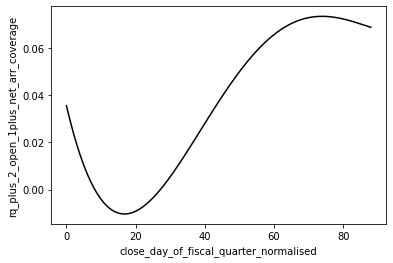

In [21]:
#### Test #2a that combined pre-grouped dataset has reasonable values

key_value_filter = 'channel co-sell_mid-market'
metric_value_filter = 'rq_plus_2_open_1plus_net_arr_coverage'

combined_agg_results.head()
index = (combined_agg_results['agg_key_value']==key_value_filter) & (combined_agg_results['metric_name']==metric_value_filter) #& (combined_agg_results['close_fiscal_quarter_name']=='FY22-Q1')
temp = combined_agg_results[index]
sns.lineplot(data=temp,hue='close_fiscal_quarter_name', y='metric_coverage',x='close_day_of_fiscal_quarter_normalised')
combined_fitted_results.head()
index = (combined_fitted_results['agg_key_value']==key_value_filter) #& (combined_agg_results['close_fiscal_quarter_name']=='FY22-Q1')
temp = combined_fitted_results[index]
sns.lineplot(data=temp, y=metric_value_filter,x='close_day_of_fiscal_quarter_normalised',color='black')

<AxesSubplot:xlabel='close_day_of_fiscal_quarter_normalised', ylabel='metric_coverage'>

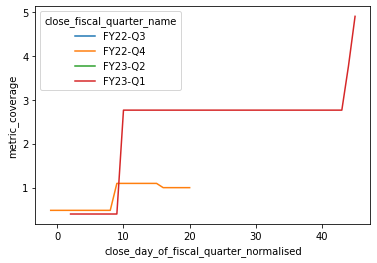

In [22]:

#### Test #2 that combined pre-grouped dataset has reasonable values

#key_value_filter = 'large_apac_apac_korea_2. growth'
key_value_filter = 'channel co-sell_mid-market_apac_1. new'
metric_value_filter = 'open_1plus_net_arr'

combined_agg_results.head()
index = (combined_agg_results['agg_key_value']==key_value_filter) & (combined_agg_results['metric_name']==metric_value_filter) #& (combined_agg_results['close_fiscal_quarter_name']=='FY22-Q1')
temp = combined_agg_results[index]
sns.lineplot(data=temp,hue='close_fiscal_quarter_name', y='metric_coverage',x='close_day_of_fiscal_quarter_normalised')
index = (combined_fitted_results['agg_key_value']==key_value_filter) #& (combined_agg_results['close_fiscal_quarter_name']=='FY22-Q1')
temp = combined_fitted_results[index]
sns.lineplot(data=temp, y=metric_value_filter + '_coverage',x='close_day_of_fiscal_quarter_normalised',color='black')

<AxesSubplot:xlabel='close_day_of_fiscal_quarter_normalised', ylabel='metric_coverage'>

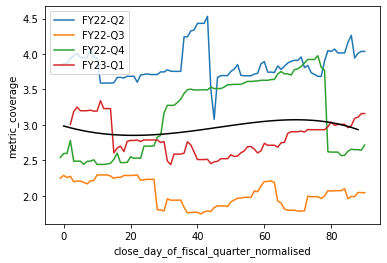

In [75]:

#### Test #2 that combined pre-grouped dataset has reasonable values

#key_value_filter = 'large_apac_apac_korea_2. growth'
key_value_filter = 'large_emea'
metric_value_filter = 'rq_plus_1_open_1plus_net_arr'

combined_agg_results.head()
index = (combined_agg_results['agg_key_value']==key_value_filter) & (combined_agg_results['metric_name']==metric_value_filter) #& (combined_agg_results['close_fiscal_quarter_name']=='FY22-Q1')
temp = combined_agg_results[index]
sns.lineplot(data=temp,hue='close_fiscal_quarter_name', y='metric_coverage',x='close_day_of_fiscal_quarter_normalised')
index = (combined_fitted_results['agg_key_value']==key_value_filter) #& (combined_agg_results['close_fiscal_quarter_name']=='FY22-Q1')
temp = combined_fitted_results[index]
sns.lineplot(data=temp, y=metric_value_filter + '_coverage',x='close_day_of_fiscal_quarter_normalised',color='black')

# Upload tables to Snowflake


In [ ]:
# Prepare aggregated metrics data to be uploaded

# set the agg_key_value to string so we can index jihu out
index = ~combined_agg_results['agg_key_value'].str.contains('jihu')
combined_agg_results = combined_agg_results[index].dropna(subset=['agg_key_value'], how='all').copy()
combined_agg_results['agg_key_value'] = combined_agg_results['agg_key_value'].astype(str)
subset = ['agg_key_value','metric_value', 'total_booked_net_arr', 'booked_net_arr','metric_coverage']
index = ~combined_agg_results['agg_key_value'].str.contains('jihu')

agg_quarter_to_upload = combined_agg_results[index].dropna(subset=subset, how='all').copy()

# nans are not welcome in the drive upload process
index = ~agg_quarter_to_upload['agg_key_value'].str.contains('na')
agg_quarter_to_upload = agg_quarter_to_upload[index].copy()

#columns need to be upper case for the drive upload process to work
agg_quarter_to_upload.columns = agg_quarter_to_upload.columns.str.upper()
agg_quarter_to_upload['LAST_UPDATED_AT'] = date.today()
fields_order = ['AGG_KEY_VALUE', 'METRIC_NAME', 'CLOSE_DAY_OF_FISCAL_QUARTER_NORMALISED', 'CLOSE_FISCAL_QUARTER_NAME', 'METRIC_VALUE', 'TOTAL_BOOKED_NET_ARR', 'BOOKED_NET_ARR', 'METRIC_COVERAGE', 'AGG_KEY_NAME','LAST_UPDATED_AT']
agg_quarter_to_upload = agg_quarter_to_upload[fields_order].copy()

agg_target_table = 'hist_quarterly_aggregated_metrics_for_coverage'

In [ ]:
# curve fitted data pre-formatting
subset = ['open_1plus_net_arr_coverage', 'open_3plus_net_arr_coverage','open_4plus_net_arr_coverage','rq_plus_1_open_1plus_net_arr_coverage','rq_plus_1_open_3plus_net_arr_coverage','rq_plus_1_open_4plus_net_arr_coverage', 'rq_plus_2_open_1plus_net_arr_coverage','rq_plus_2_open_3plus_net_arr_coverage','rq_plus_2_open_4plus_net_arr_coverage']
index = ~combined_fitted_results['agg_key_value'].str.contains('jihu')
fitted_curves_to_upload = combined_fitted_results[index].dropna(subset=subset, how='all').copy()

fitted_curves_to_upload['key_agg_day'] = fitted_curves_to_upload['agg_key_value'] + '_' + for_gsheet['close_day_of_fiscal_quarter_normalised'].astype(str) 
fitted_curves_to_upload['last_updated_at'] = date.today()
fitted_curves_to_upload = ['key_agg_day','agg_key_name','agg_key_value','close_day_of_fiscal_quarter_normalised','bookings_linearity','open_1plus_net_arr_coverage', 'open_3plus_net_arr_coverage','open_4plus_net_arr_coverage','rq_plus_1_open_1plus_net_arr_coverage','rq_plus_1_open_3plus_net_arr_coverage','rq_plus_1_open_4plus_net_arr_coverage', 'rq_plus_2_open_1plus_net_arr_coverage','rq_plus_2_open_3plus_net_arr_coverage','rq_plus_2_open_4plus_net_arr_coverage','last_updated_at']

# columns in the CSV MUST BE UPPERCASE, if not, the drive process might fail
fitted_curves_to_upload = fitted_curves_to_upload[fields_order].copy()
fitted_curves_to_upload.columns = fitted_curves_to_upload.columns.str.upper()

curves_target_table = 'hist_quarterly_coverage_fitted_curves'

In [ ]:
# upload the aggregated file to snowflake
output_filename = agg_target_table + ".json"
agg_quarter_to_upload.to_json(output_filename, orient="records", date_format="iso")

snowflake_stage_load_copy_remove(
    output_filename,
    f"{raw_db_name}.sales_analytics.sales_analytics_load",
    f"{raw_db_name}.sales_analytics.hist_quarterly_coverage_fitted_curves",
    snowflake_engine,
)

In [ ]:
# upload the curves fitted file to snowflake
output_filename = curves_target_table + ".json"
fitted_curves_to_upload.to_json(output_filename, orient="records", date_format="iso")

snowflake_stage_load_copy_remove(
    output_filename,
    f"{raw_db_name}.sales_analytics.sales_analytics_load",
    f"{raw_db_name}.sales_analytics.hist_quarterly_aggregated_metrics_for_coverage",
    snowflake_engine,
)